In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import rgb2hex
from matplotlib import cm
import numpy as np
import networkx as nx
import datetime as dt
import random
import pickle
import math
import csv
import os

%matplotlib inline

In [2]:
home_dir = os.path.expanduser("~")
code_dir = os.path.join(home_dir,"Developer","GitHub","opportunistic-attachment")
figs_dir = os.path.join(code_dir,"figures")

In [3]:
from src.models import InOneOutOne, InOneOutTwo, InTwoOutOne, InOutThree, InTwoOutTwo

### Run the optimal growth model

In [4]:
networks = []

for i in range(4,10):
    # INITIALIZE MODEL
    run = InOneOutOne(m=3,alpha=0.95,select="optimal")
    # RUN MODEL
    run.grow(i)
    # REMOVE LAST NODE
    run.G.remove_node(max(run.G.nodes))
    # SCORE POSSIBILITIES
    run.V = run.explore()
    max_score = max(run.V.values())
    run.V = {k: v/max_score for k,v in run.V.items()}
    # ADD NODES
    run.V.update({k: 0.99 for k in run.nodes})
    nx.set_node_attributes(run.G, run.V, 'size')
    # SAVE MODEL
    networks.append(run)

In [5]:
for run in networks:
    print(run.nodes)
    print(run.G.nodes(data=True))

{0, 1, 2, 9}
[(0, {'score': 0.3333333333333333, 'size': 0.99}), (1, {'score': 0.3333333333333333, 'size': 0.99}), (2, {'score': 0.3333333333333333, 'size': 0.99}), (3, {'size': 0.8693496602065471}), (4, {'size': 1.0}), (5, {'size': 1.0}), (6, {'size': 0.8693496602065471}), (7, {'size': 0.8693496602065471}), (8, {'size': 1.0})]
{0, 1, 2, 9, 16}
[(0, {'score': 0.3333333333333333, 'size': 0.99}), (1, {'score': 0.3333333333333333, 'size': 0.99}), (2, {'score': 0.3333333333333333, 'size': 0.99}), (3, {'size': 0.4975963566761836}), (4, {'size': 0.5349859472215122}), (5, {'size': 1.0}), (6, {'size': 0.8693495300632132}), (7, {'size': 0.6183791530137663}), (8, {'size': 0.6803381296711617}), (9, {'size': 0.99}), (10, {'size': 0.46661770833123273}), (11, {'size': 0.46661770833123273}), (12, {'size': 0.49759635667618357}), (13, {'size': 1.0}), (14, {'size': 0.5349859472215122}), (15, {'size': 0.6183791530137663})]
{0, 1, 2, 9, 16, 25}
[(0, {'score': 0.3333333333333333, 'size': 0.99}), (1, {'score

### Visualizations

In [6]:
def score(G, alpha=0.95):
    # Calculate the PageRank scores
    scores = nx.pagerank(G,alpha=alpha,max_iter=1000)
    return scores

def explore(G, nodes):
    V = {}
    possibilities = G.nodes() - nodes
    for pos in possibilities: # TODO: experiment
        H = G.subgraph(nodes | {pos})
        V[pos] = score(H)[pos]
    return V

In [7]:
# PICK YOUR FAVORITES
plot_network = {}
plot_nodes = {}
for step in range(4):
    
    # GET THE NETWORK
    plot_network[step] = networks[step].G

    # NODE PROPERTIES
    plot_nodes[step] = {'set':{node for node in networks[step].nodes if node in networks[step].G.nodes}}
    plot_nodes[step]['max'] = max(networks[step].G.nodes)
    plot_nodes[step]['color'] = ["#852d90" if node in networks[step].nodes else "#999999" for node in networks[step].G.nodes]

# NODE SIZE AND POSITIONS
net_final = plot_network[3].subgraph(plot_nodes[3]['set'])
pos_final = nx.kamada_kawai_layout(net_final)
for step in range(4):
    # Use the final network
    G = plot_network[3].subgraph(range(plot_nodes[step]['max']+1))
    # SCORE POSSIBILITIES
    V = explore(G, plot_nodes[step]['set'])
    max_score = max(V.values())
    V = {k: v/max_score for k,v in V.items()}
    for gamma in [0,1,2,3,4,5,6,7,8,9]:
        plot_nodes[step][f'size_{gamma}'] = [V[node]**gamma if node in V else 0.99 for node in G.nodes]
    # HIGHLIGHT KEY NODE
    nodes = [node for node in G.nodes if node in plot_nodes[step]['set']]+[plot_nodes[step]['size_1'].index(1)]
    plot_nodes[step]['node'] = [1.5 if node in nodes else 0.5 for node in G.nodes]
    # STORE POSITIONS
    pos = nx.spring_layout(G,pos=pos_final,fixed=pos_final.keys(),k=0.35)
    plot_nodes[step]['pos'] = pos

# FIX THE FIRST LAYOUT (flip vertically)
plot_nodes[0]['pos'] = {node: (x, -y) for node, (x, y) in plot_nodes[0]['pos'].items()}

In [8]:
# Grab colors matching the examples
color = {}
for term, cmap_name in zip(["pre","post"],["Blues","BuPu"]):
    cmap = plt.colormaps[cmap_name]
    color[term] = rgb2hex([cmap(i) for i in np.linspace(0, 0.8, 10)][-1])
color

{'pre': '#1764ab', 'post': '#852d90'}

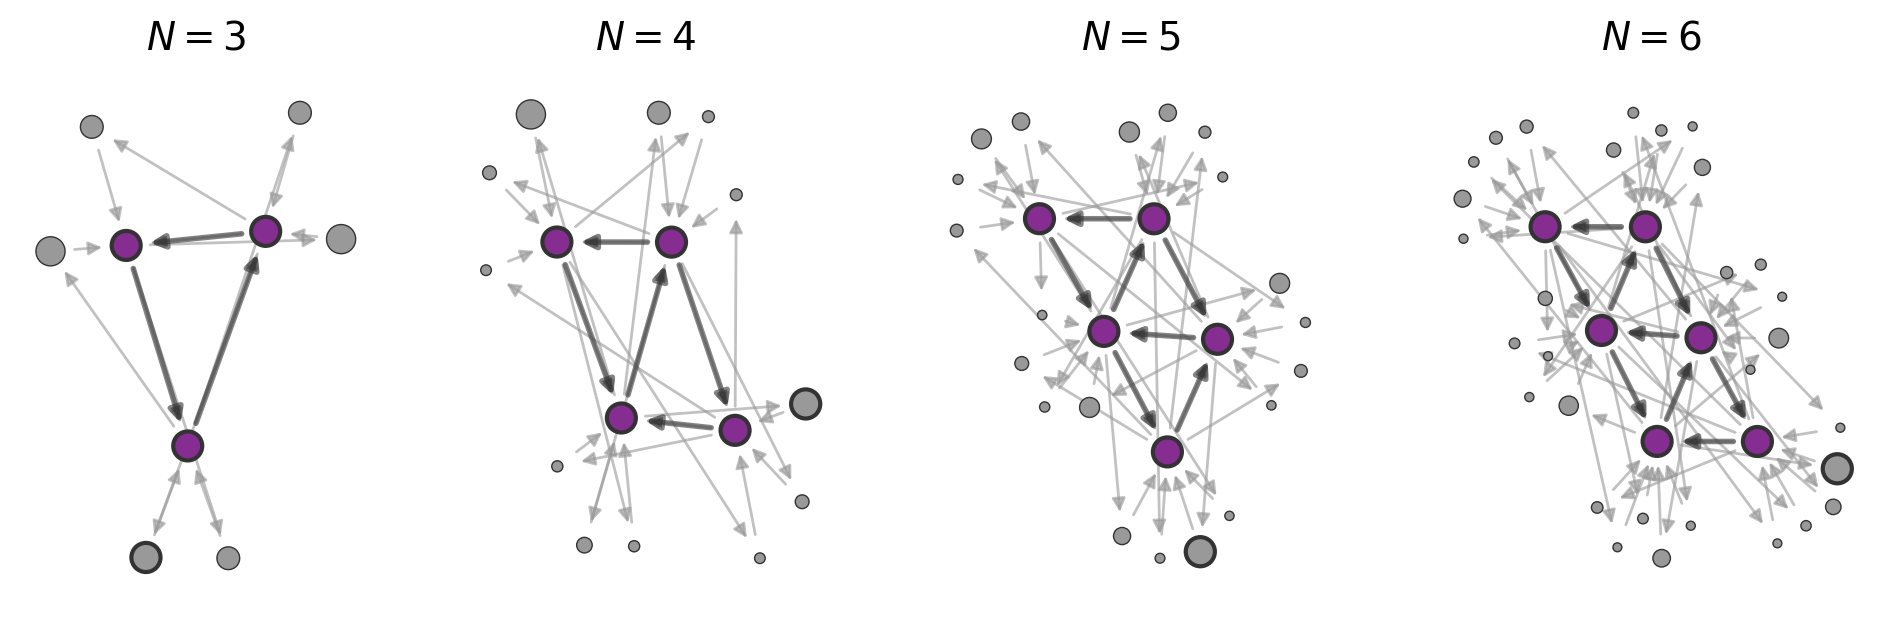

In [10]:
# put it in the same folder as the other figures
output = "_".join(["i1o1","m"+str(3),"a"+str(0.95)])

for gamma in [4]:
    # Create a figure with a specific size and DPI
    fig = plt.figure(figsize=(12, 3.5), dpi=200)

    # Create a GridSpec object
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1.1, 1.2, 1.3])

    # Create the subplots
    ax = [plt.subplot(gs[i]) for i in range(4)]

    # draw networks
    for ax_i in range(4):

        step = ax_i

        # Grab network & node properties
        G = plot_network[3].subgraph(range(plot_nodes[step]['max']+1))
        ns = plot_nodes[step]['set']
        pos = plot_nodes[step]['pos']
        color = plot_nodes[step]['color']
        size = [10+100*x for x in plot_nodes[step][f'size_{gamma}']]
        borders = plot_nodes[step]['node']

        nx.draw_networkx_nodes(G, pos, node_size=size, node_color=color, linewidths=borders,
                            edgecolors='#333333', ax=ax[ax_i])
        nx.draw_networkx_edges(G, pos, edge_color='#999999', ax=ax[ax_i], width=1, alpha=0.6)
        nx.draw_networkx_edges(G.subgraph(ns), pos, edge_color='#333333', ax=ax[ax_i], width=2, alpha=0.6)
        ax[ax_i].set_axis_off()
        ax_i += 1

    ax[0].set_title(r'$N = 3$', fontsize=14)
    ax[1].set_title(r'$N = 4$', fontsize=14)
    ax[2].set_title(r'$N = 5$', fontsize=14)
    ax[3].set_title(r'$N = 6$', fontsize=14)

    plt.savefig(os.path.join(figs_dir,f"optimal_g{gamma}.jpeg"), bbox_inches='tight', dpi=300)
    plt.savefig(os.path.join(figs_dir,f"optimal_g{gamma}.pdf"), bbox_inches='tight')
    plt.show()
    plt.close()
    # I usually run it a few times until the network line up nicely

